# <center>Modelling</center>

## Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_rows = 999

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.preprocessing import sequence
from keras.utils import plot_model
from keras import optimizers

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import xgboost

import warnings
warnings.filterwarnings('ignore')

## Load data

In [3]:
PATH = 'preprocessing_categorical/'

In [4]:
X_train = pd.read_csv(PATH + 'X_train.csv', index_col=0)
y_train = pd.read_csv(PATH + 'y_train.csv', index_col=0)
y_train_categories = pd.read_csv(PATH + 'y_train_categories.csv', index_col=0)
y_train_one_hot = pd.read_csv(PATH + 'y_train_one_hot.csv', index_col=0)

In [5]:
X_train_os = pd.read_csv(PATH + 'X_train_os.csv', index_col=0)
y_train_os = pd.read_csv(PATH + 'y_train_os.csv', index_col=0)
y_train_os_categories = pd.read_csv(PATH + 'y_train_os_categories.csv', index_col=0)
y_train_os_one_hot = pd.read_csv(PATH + 'y_train_os_one_hot.csv', index_col=0)

In [6]:
X_test = pd.read_csv(PATH + 'X_test.csv', index_col=0)

In [7]:
PATH = 'Dataset'
PATH_TO_test_data = PATH + '/' + 'test.csv'
test_data = pd.read_csv(PATH_TO_test_data)

In [8]:
def save_predictions(y_test_pred, test_data, add_one_or_not=True):
    y_test_pred_df = pd.DataFrame({'damage_grade': y_test_pred})
    if add_one_or_not == True:
        y_test_pred_df['damage_grade'] += 1
    y_test_pred_df = y_test_pred_df.astype(str)
    y_test_pred_df['damage_grade'] = 'Grade ' + y_test_pred_df['damage_grade']

    # Add building_id to the Data frame.
    y_test_pred_df['building_id'] = test_data.building_id
    y_test_pred_df = pd.DataFrame({'building_id': y_test_pred_df.building_id, 'damage_grade': y_test_pred_df.damage_grade})
    y_test_pred_df.to_csv('prediction_lightgbm.csv', index=False)
    return y_test_pred_df

In [9]:
def feature_importance(model, X_train):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    features = X_train.columns
    important_features = []
    important_features_scores = []
    for index in indices:
        important_features.append(features[index])
        important_features_scores.append(importances[index])
    feature_importance_df = pd.Series(data=important_features_scores, index=important_features)
    return feature_importance_df

## Drop highly correlated columns

In [10]:
corr_matrix = X_train_os.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [11]:
X_train_os = X_train_os.drop(columns=to_drop)

In [12]:
X_train_os.shape

(1021990, 49)

In [13]:
X_test = X_test.drop(columns=to_drop)

## Modelling

- Uncomment all the below cells and run, which reproduces the score on the leaderboard.

In [28]:
# xgb = xgboost.XGBClassifier(n_estimators=1000, learning_rate=0.1, subsample=0.7, colsample_bytree=1)
# model = xgb.fit(X_train_os, y_train_os_categories, verbose=1000)

In [ ]:
# model

In [41]:
# d_train = xgboost.DMatrix(X_train_os, label = np.array(y_train_os_categories.damage_grade - 1))

In [14]:
'''
params = {}
params['learning_rate'] = 0.1
params['booster'] = 'gbtree'
params['objective'] = 'multi:softmax'
params['metric'] = 'mlogloss'
params['max_depth'] = 20
params['num_class'] = 5
params['colsample_bytree'] = 1
params['subsample'] = 0.7
'''

"\nparams = {}\nparams['learning_rate'] = 0.1\nparams['booster'] = 'gbtree'\nparams['objective'] = 'multi:softmax'\nparams['metric'] = 'mlogloss'\nparams['max_depth'] = 20\nparams['num_class'] = 5\nparams['colsample_bytree'] = 1\nparams['subsample'] = 0.7\n"

In [ ]:
# xgbClassifier = xgboost.train(params, d_train, 5000)

- Save the model file.

In [ ]:
import pickle
pkl_filename = "xgboost_latest.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [ ]:
model

In [32]:
y_train_pred = model.predict(X_train_os)

In [36]:
y_train_pred.shape, y_train_os.shape

((1021990,), (1021990, 1))

In [41]:
y_pred_np = np.array(y_train_os_categories.damage_grade)

In [42]:
Accuracy = accuracy_score(y_pred_np, y_train_pred) * 100
F1_score = f1_score(y_pred_np, y_train_pred, average='weighted')

In [43]:
Accuracy, F1_score

(97.52580749322401, 0.9752548313724714)

- Feature importance of all top features.

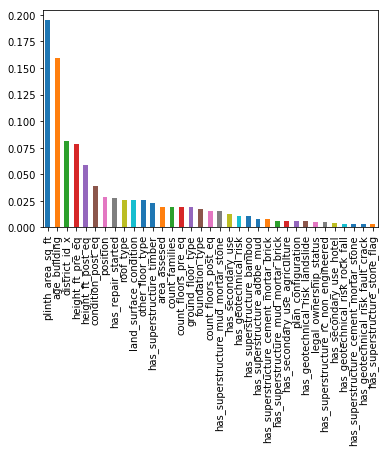

In [44]:
feature_importance_df = feature_importance(model, X_train_os)
feature_importance_df.iloc[:35].plot('bar')

In [ ]:
y_test_pred = model.predict(X_test)
y_test_pred

In [ ]:
y_test_pred

In [ ]:
#y_test_pred_int = np.argmax(y_test_pred, axis=1)
#y_test_pred_int

- Save the predictions in the local computer

In [ ]:
out = save_predictions(y_test_pred, test_data, False)

In [ ]:
out.damage_grade.value_counts().plot('bar')

In [ ]:
np.array(y_train_os_categories.damage_grade - 1)

## Lightgbm

In [38]:
import lightgbm as lgb

d_train = lgb.Dataset(X_train_os, label = np.array(y_train_os_categories.damage_grade - 1))

params = {}
params['learning_rate'] = 0.03
params['boosting_type'] = 'gbdt'
params['objective'] = 'multiclass'
params['metric'] = 'multi_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 500
params['min_data'] = 50
params['max_depth'] = 200
params['num_class'] = 5

In [ ]:
lgbmClassifier = lgb.train(params, d_train, 10000)

In [ ]:
import pickle
pkl_filename = "lgm_classifier_new.pkl"  
with open(pkl_filename, 'wb') as file:
    pickle.dump(lgbmClassifier, file)

In [ ]:
y_pred = lgbmClassifier.predict(X_test)

In [ ]:
y_pred_int = [np.argmax(row) for row in y_pred]

In [ ]:
out = save_predictions(y_pred_int, test_data)

In [ ]:
out.damage_grade.value_counts().plot('bar')